In [2]:
from BIDS import BIDS_Global_info, BIDS_Family

In [3]:
#Lets import the class that represent a whole data set.
from BIDS import BIDS_Global_info, BIDS_Family
# You can parse multiple datasets and select what parent folder are read (e.g. rawdata, derivatives)
bids_global_object = BIDS_Global_info(['/data1/practical-sose23/dataset-verse19',  '/data1/practical-sose23/dataset-verse20'],['rawdata',"derivatives"], additional_key = ["ct", "subreg", "cortex"], verbose=True)
#The Parser will inform you about every non standard files. To add additional key add them to additional_key list, so you don't get the msg that this is not a valid key
from BIDS.snapshot2D import create_snapshot,Snapshot_Frame,Visualization_Type,Image_Modes
from pathlib import Path
from IPython.display import Image

[!] Unknown format seg-ano in file sub-verse649_dir-sag_seg-ano.nii.gz
[!] Unknown format iso-ctd in file sub-verse616_dir-iso_iso-ctd.json
[!] Unknown format subreg in file sub-verse559_CT-sag_seg-ano_subreg.nii.gz


## Masterlist Understanding
Let's have a look at the master file and extract informations related to dataset

In [4]:
import pandas as pd
gt_df = pd.read_excel('../dataset/VerSe_masterlist.xlsx', index_col=0)
gt_df.head()

,Full_Id,Castellvi,2a/3a Side,Sacrum Seg,Last_L,Split,Comment
Id,,,,,,,
4,sub-verse004,0,NaN,1.0,L5,NaN,NaN
5,sub-verse005,0,NaN,1.0,L5,NaN,NaN
6,sub-verse006,0,NaN,1.0,L5,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,sub-verse008,0,NaN,1.0,L5,NaN,NaN


In [5]:
print("Number of rows: {}".format(len(gt_df.index)))
print("Number of null rows: {}".format(gt_df["Full_Id"].isnull().sum()))

Number of rows: 325
Number of null rows: 40


In [6]:
# print out the files that does not have information in masterlist
null_indexes = gt_df.index[gt_df["Sacrum Seg"].isnull()].tolist()
print("Null row indexes: {}".format(null_indexes))


Null row indexes: [7, 11, 12, 18, 59, 75, 81, 100, 105, 112, 119, 125, 150, 205, 207, 217, 221, 225, 230, 242, 250, 544, 596, 640, 641, 643, 645, 647, 648, 650, 651, 707, 710, 754, 756, 757, 764, 767, 803, 814]


In [7]:
null_indexes_with_sacrum_seg = [index for index in null_indexes if pd.isnull(gt_df.loc[index, 'Sacrum Seg'])]
print("Null row indexes with a value for 'sacrum_seg': {}".format(null_indexes_with_sacrum_seg))


Null row indexes with a value for 'sacrum_seg': [7, 11, 12, 18, 59, 75, 81, 100, 105, 112, 119, 125, 150, 205, 207, 217, 221, 225, 230, 242, 250, 544, 596, 640, 641, 643, 645, 647, 648, 650, 651, 707, 710, 754, 756, 757, 764, 767, 803, 814]


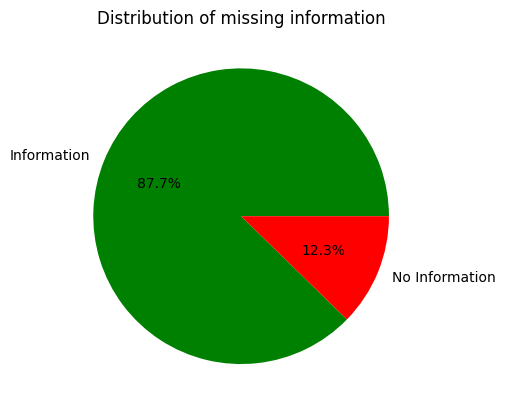

In [8]:
# plot those missing information distribution over the dataset
import matplotlib.pyplot as plt


null_count = gt_df["Full_Id"].isnull().sum()
non_null_count = len(gt_df) - null_count
labels = ["Information", "No Information"]
values = [non_null_count, null_count]
colors = ["green", "red"]

plt.pie(values, labels=labels, colors=colors, autopct="%1.1f%%")
plt.title("Distribution of missing information" , loc='center')
plt.show()



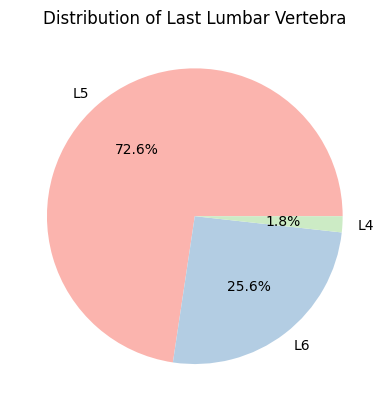

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the count of Last_L values for the entire dataset
last_l_counts = gt_df['Last_L'].value_counts().reset_index()

# Rename columns for better readability
last_l_counts.columns = ['Last_L', 'Count']

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(last_l_counts['Count'], labels=last_l_counts['Last_L'], autopct="%1.1f%%", colors=plt.cm.Pastel1.colors)
ax.set_title('Distribution of Last Lumbar Vertebra')

plt.show()


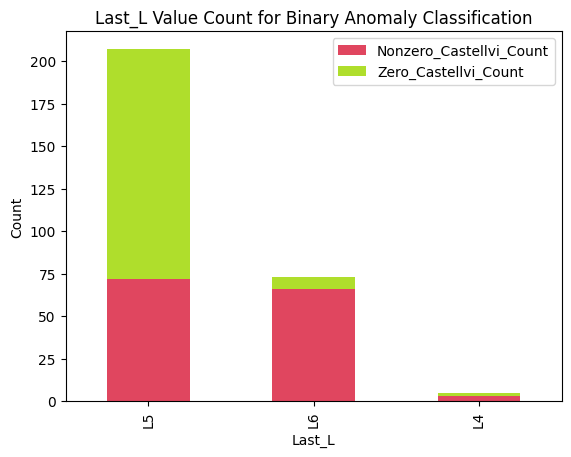

In [9]:
# plot the binary class distribution

# Filter the rows with Castellvi different than 0
castellvi_nonzero = gt_df[gt_df['Castellvi'] != 0]

# Filter the rows with Castellvi equal to 0
castellvi_zero = gt_df[gt_df['Castellvi'] == 0]

# Calculate the count of Last_L values for each group
castellvi_nonzero_count = castellvi_nonzero['Last_L'].value_counts().reset_index()
castellvi_zero_count = castellvi_zero['Last_L'].value_counts().reset_index()

# Rename columns for better readability
castellvi_nonzero_count.columns = ['Last_L', 'Nonzero_Castellvi_Count']
castellvi_zero_count.columns = ['Last_L', 'Zero_Castellvi_Count']

# Merge the two count DataFrames on the Last_L column
merged_counts = pd.merge(castellvi_nonzero_count, castellvi_zero_count, on='Last_L')

# Create the bar chart
fig, ax = plt.subplots()
merged_counts.plot(x='Last_L', kind='bar', stacked=True, ax=ax, color=['#e0465f', '#afde2c'])
ax.set_title('Last_L Value Count for Binary Anomaly Classification')
ax.set_xlabel('Last_L')
ax.set_ylabel('Count')
plt.show()


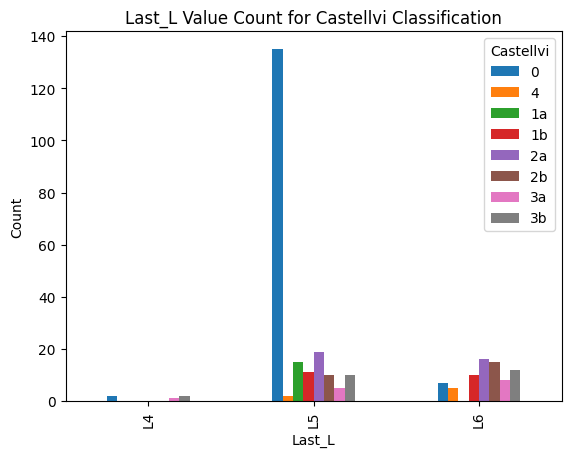

In [10]:
# Let's plot the sub_classes distribution
# Group by Castellvi and Last_L values and calculate the count
grouped_counts = gt_df.groupby(['Castellvi', 'Last_L']).size().reset_index(name='Count')

# Rename columns for better readability
grouped_counts.columns = ['Castellvi', 'Last_L', 'Count']

# Create the grouped bar chart
fig, ax = plt.subplots()
grouped_counts.pivot(index='Last_L', columns='Castellvi', values='Count').plot(kind='bar', stacked=False, ax=ax)
ax.set_title('Last_L Value Count for Castellvi Classification')
ax.set_xlabel('Last_L')
ax.set_ylabel('Count')
plt.show()

## BIDS Families

IDS splits data samples roughly into:
- Subject: different patients
- Sessions: one patient can have multiple scans

You use enumerate_subjects to iterate over different, unique subjects.
Then, you can use queries to apply various filters. If you use flatten=True, that means you filter inividual files, and not a group/family of files.


Everyone needs a family! 
Files that are generated from others should belong to a family. We automatically find related files and cluster them into a dictionary.


In [27]:
for i in bids_global_object.subjects:
    print(i)

verse400
verse041
verse416
verse065
verse402
verse153
verse102
verse111
verse124
verse149
verse242
verse068
verse410
verse269
verse095
verse072
verse138
verse116
verse145
verse059
verse417
verse415
verse139
verse113
verse096
verse053
verse075
verse043
verse082
verse048
verse405
verse029
verse122
verse074
verse066
verse011
verse007
verse080
verse078
verse073
verse133
verse006
verse130
verse408
verse013
verse033
verse264
verse230
verse207
verse143
verse135
verse070
verse040
verse064
verse151
verse137
verse104
verse141
verse127
verse009
verse100
verse119
verse031
verse024
verse205
verse067
verse051
verse150
verse085
verse022
verse018
verse061
verse023
verse144
verse403
verse409
verse016
verse412
verse058
verse030
verse112
verse225
verse401
verse404
verse105
verse252
verse147
verse221
verse254
verse076
verse005
verse081
verse050
verse046
verse407
verse055
verse026
verse236
verse146
verse125
verse034
verse406
verse107
verse083
verse097
verse060
verse271
verse101
verse250
verse260
verse088
v

In [62]:
subs = ['sub-verse041', 'sub-verse065', 'sub-verse153', 'sub-verse102', 'sub-verse111', 'sub-verse124', 'sub-verse149', 'sub-verse068', 'sub-verse269', 'sub-verse095', 'sub-verse072', 'sub-verse138', 'sub-verse116', 'sub-verse145', 'sub-verse139', 'sub-verse113', 'sub-verse096', 'sub-verse053', 'sub-verse043', 'sub-verse082', 'sub-verse048', 'sub-verse029', 'sub-verse122', 'sub-verse074', 'sub-verse066', 'sub-verse080', 'sub-verse078', 'sub-verse073', 'sub-verse133', 'sub-verse006', 'sub-verse130', 'sub-verse013', 'sub-verse033', 'sub-verse264', 'sub-verse143', 'sub-verse135', 'sub-verse070', 'sub-verse040', 'sub-verse064', 'sub-verse151', 'sub-verse137', 'sub-verse104', 'sub-verse141', 'sub-verse127', 'sub-verse009', 'sub-verse031', 'sub-verse024', 'sub-verse067', 'sub-verse051', 'sub-verse085', 'sub-verse022', 'sub-verse061', 'sub-verse023', 'sub-verse144', 'sub-verse016', 'sub-verse058', 'sub-verse030', 'sub-verse252', 'sub-verse147', 'sub-verse254', 'sub-verse076', 'sub-verse005', 'sub-verse050', 'sub-verse046', 'sub-verse055', 'sub-verse026', 'sub-verse236', 'sub-verse146', 'sub-verse034', 'sub-verse107', 'sub-verse083', 'sub-verse097', 'sub-verse060', 'sub-verse271', 'sub-verse101', 'sub-verse260', 'sub-verse088', 'sub-verse134', 'sub-verse004', 'sub-verse038', 'sub-verse091', 'sub-verse047', 'sub-verse010', 'sub-verse276', 'sub-verse071', 'sub-verse008', 'sub-verse063', 'sub-verse015', 'sub-verse154', 'sub-verse014', 'sub-verse152', 'sub-verse093', 'sub-verse131', 'sub-verse056', 'sub-verse032', 'sub-verse020', 'sub-verse036', 'sub-verse108', 'sub-verse092', 'sub-verse257', 'sub-verse054', 'sub-verse089', 'sub-verse751', 'sub-verse529', 'sub-verse627', 'sub-verse522', 'sub-verse716', 'sub-verse588', 'sub-verse835', 'sub-verse700', 'sub-verse570', 'sub-verse500', 'sub-verse505', 'sub-verse649', 'sub-verse517', 'sub-verse711', 'sub-verse760', 'sub-verse576', 'sub-verse606', 'sub-verse581', 'sub-verse560', 'sub-verse592', 'sub-verse598', 'sub-verse768', 'sub-verse646', 'sub-verse713', 'sub-verse750', 'sub-verse551', 'sub-verse580', 'sub-verse717', 'sub-verse712', 'sub-verse571', 'sub-verse584', 'sub-verse554', 'sub-verse607', 'sub-verse825', 'sub-verse621', 'sub-verse605', 'sub-verse616', 'sub-verse546', 'sub-verse635', 'sub-verse506', 'sub-verse507', 'sub-verse504', 'sub-verse565', 'sub-verse620', 'sub-verse524', 'sub-verse604', 'sub-verse753', 'sub-verse526', 'sub-verse626', 'sub-verse530', 'sub-verse701', 'sub-verse703', 'sub-verse599', 'sub-verse547', 'sub-verse609', 'sub-verse761', 'sub-verse807', 'sub-verse578', 'sub-verse503', 'sub-verse518', 'sub-verse521', 'sub-verse541', 'sub-verse513', 'sub-verse718', 'sub-verse519', 'sub-verse824', 'sub-verse821', 'sub-verse552', 'sub-verse602', 'sub-verse613', 'sub-verse573', 'sub-verse511', 'sub-verse719', 'sub-verse512', 'sub-verse629', 'sub-verse614', 'sub-verse708', 'sub-verse714', 'sub-verse642', 'sub-verse808', 'sub-verse582', 'sub-verse810', 'sub-verse559', 'sub-verse769', 'sub-verse759', 'sub-verse572', 'sub-verse525', 'sub-verse587', 'sub-verse617', 'sub-verse527', 'sub-verse603', 'sub-verse612', 'sub-verse561', 'sub-verse509', 'sub-verse533', 'sub-verse532', 'sub-verse563', 'sub-verse705', 'sub-verse535', 'sub-verse556', 'sub-verse590', 'sub-verse600', 'sub-verse758', 'sub-verse594', 'sub-verse755', 'sub-verse813', 'sub-verse564', 'sub-verse636', 'sub-verse550', 'sub-verse591', 'sub-verse811', 'sub-verse534', 'sub-verse597', 'sub-verse619', 'sub-verse833', 'sub-verse549', 'sub-verse557', 'sub-verse539', 'sub-verse510', 'sub-verse569', 'sub-verse763', 'sub-verse817', 'sub-verse762', 'sub-verse615', 'sub-verse536', 'sub-verse752', 'sub-verse804', 'sub-verse766', 'sub-verse555', 'sub-verse531', 'sub-verse593', 'sub-verse514', 'sub-verse631', 'sub-verse558', 'sub-verse540', 'sub-verse508', 'sub-verse537', 'sub-verse801', 'sub-verse545', 'sub-verse585', 'sub-verse818', 'sub-verse815', 'sub-verse823', 'sub-verse702', 'sub-verse816', 'sub-verse715', 'sub-verse644', 'sub-verse709', 'sub-verse586', 'sub-verse623', 'sub-verse618', 'sub-verse577', 'sub-verse601', 'sub-verse806', 'sub-verse765', 'sub-verse802', 'sub-verse502', 'sub-verse805', 'sub-verse826', 'sub-verse820', 'sub-verse704', 'sub-verse553', 'sub-verse809', 'sub-verse542', 'sub-verse706']

In [63]:
gt_df.loc[gt_df['Full_Id'] == subs]['Castellvi'].values

ValueError: ('Lengths must match to compare', (325,), (267,))

In [10]:
#Let's get a few basic statistics about our data set first
print(len(bids_global_object.subjects))

bids_families = []
fam_count = {}
for subject_name, subject_container in bids_global_object.enumerate_subjects(sort = True):

    query = subject_container.new_query(flatten=False) #<- flatten=False means we search for family
    #For the project, we need a ct scan, a segmentation and the centroid data. So let's filter for that
    query.filter('format','ct')
    query.filter('seg','vert')

    i = 0

    #now we can loop over families and gather some information
    for bids_family in query.loop_dict(sort=True):
        bids_families.append(bids_family)
        i = i + 1

    
    fam_count[query.subject.name] = i
        

print(len(bids_families))
print(fam_count)
    

323
342
{'verse004': 1, 'verse005': 1, 'verse006': 1, 'verse007': 1, 'verse008': 1, 'verse009': 1, 'verse010': 1, 'verse011': 1, 'verse012': 1, 'verse013': 1, 'verse014': 1, 'verse015': 1, 'verse016': 1, 'verse018': 1, 'verse020': 1, 'verse022': 1, 'verse023': 1, 'verse024': 1, 'verse026': 1, 'verse029': 1, 'verse030': 1, 'verse031': 1, 'verse032': 1, 'verse033': 1, 'verse034': 1, 'verse036': 1, 'verse038': 1, 'verse040': 1, 'verse041': 1, 'verse043': 1, 'verse046': 1, 'verse047': 1, 'verse048': 1, 'verse050': 1, 'verse051': 1, 'verse053': 1, 'verse054': 1, 'verse055': 1, 'verse056': 1, 'verse058': 1, 'verse059': 1, 'verse060': 1, 'verse061': 1, 'verse063': 1, 'verse064': 1, 'verse065': 1, 'verse066': 1, 'verse067': 1, 'verse068': 1, 'verse070': 1, 'verse071': 1, 'verse072': 1, 'verse073': 1, 'verse074': 1, 'verse075': 1, 'verse076': 1, 'verse078': 1, 'verse080': 1, 'verse081': 1, 'verse082': 1, 'verse083': 1, 'verse085': 1, 'verse088': 1, 'verse089': 1, 'verse091': 1, 'verse092': 1, '

In [46]:
fam_count

{'verse004': 1,
 'verse005': 1,
 'verse006': 1,
 'verse007': 1,
 'verse008': 1,
 'verse009': 1,
 'verse010': 1,
 'verse011': 1,
 'verse012': 1,
 'verse013': 1,
 'verse014': 1,
 'verse015': 1,
 'verse016': 1,
 'verse018': 1,
 'verse020': 1,
 'verse022': 1,
 'verse023': 1,
 'verse024': 1,
 'verse026': 1,
 'verse029': 1,
 'verse030': 1,
 'verse031': 1,
 'verse032': 1,
 'verse033': 1,
 'verse034': 1,
 'verse036': 1,
 'verse038': 1,
 'verse040': 1,
 'verse041': 1,
 'verse043': 1,
 'verse046': 1,
 'verse047': 1,
 'verse048': 1,
 'verse050': 1,
 'verse051': 1,
 'verse053': 1,
 'verse054': 1,
 'verse055': 1,
 'verse056': 1,
 'verse058': 1,
 'verse059': 1,
 'verse060': 1,
 'verse061': 1,
 'verse063': 1,
 'verse064': 1,
 'verse065': 1,
 'verse066': 1,
 'verse067': 1,
 'verse068': 1,
 'verse070': 1,
 'verse071': 1,
 'verse072': 1,
 'verse073': 1,
 'verse074': 1,
 'verse075': 1,
 'verse076': 1,
 'verse078': 1,
 'verse080': 1,
 'verse081': 1,
 'verse082': 1,
 'verse083': 1,
 'verse085': 1,
 'verse0

In [41]:
for i in gt_df['Full_Id'].values.tolist():
    print(i)
    break

sub-verse004


In [12]:
# print out the subjects that have more than one family
[gt_df["Full_Id"][i] for i in range(400,418)]

['sub-verse400_split-verse155',
 'sub-verse401_split-verse253',
 'sub-verse402_split-verse251',
 'sub-verse403_split-verse255',
 'sub-verse404_split-verse256',
 'sub-verse405_split-verse259',
 'sub-verse406_split-verse261',
 'sub-verse407_split-verse262',
 'sub-verse408_split-verse265',
 'sub-verse409_split-verse266',
 'sub-verse410_split-verse267',
 'sub-verse411_split-verse270',
 'sub-verse412_split-verse290',
 'sub-verse413_split-verse272',
 'sub-verse414_split-verse273',
 'sub-verse415_split-verse275',
 'sub-verse416_split-verse279',
 'sub-verse417_split-verse278']

## Data Visualization

In [13]:
# ct_file = bids_family["ct"][0].file["nii.gz"]
# vert_file = bids_family["msk_seg-vert"][0].file["nii.gz"]
# ctd_file = bids_family["ctd_seg-subreg"][0].file["json"]
# out_file = "/tmp/snap.jpg"
# ct_frame = Snapshot_Frame(ct_file,segmentation=vert_file,centroids=ctd_file,sagittal=True,coronal=True,mode='CT')
# create_snapshot(out_file,[ct_frame])
# Image(filename=out_file) 

## Cutouts - Region of Interest 
See dev-daniel branch for better understanding of the cutouts. 

In [13]:
#get the first BIDS family of a subject:
subject_container = bids_global_object.subjects['verse033']
query = subject_container.new_query(flatten = False)
query.filter('format','ct')
query.filter('seg','vert')
family = next(query.loop_dict())

v_idx2name = {
     1: "C1",     2: "C2",     3: "C3",     4: "C4",     5: "C5",     6: "C6",     7: "C7", 
     8: "T1",     9: "T2",    10: "T3",    11: "T4",    12: "T5",    13: "T6",    14: "T7",    15: "T8",    16: "T9",    17: "T10",   18: "T11",   19: "T12", 28: "T13",
    20: "L1",    21: "L2",    22: "L3",    23: "L4",    24: "L5",    25: "L6",    
    26: "S1",    29: "S2",    30: "S3",    31: "S4",    32: "S5",    33: "S6",
    27: "Cocc"
}
v_name2idx = {value: key for key,value in v_idx2name.items()}
v_idx_order = list(v_idx2name.keys())

v_idx = v_name2idx[gt_df["Last_L"][33]]

In [21]:
import numpy as np
from BIDS import BIDS_Family

def get_cutout(bids_family: BIDS_Family, roi_object_idx: list[int], return_seg = False):

    ct_nii = bids_family["ct"][0].open_nii()
    seg_nii = bids_family["msk_seg-vertsac"][0].open_nii()
    print(ct_nii)

    #separate arrays to manipulate the ct_nii_array 
    vert_arr = seg_nii.get_array()
    ct_arr = ct_nii.get_array()

    print(vert_arr)

    #get all indices of voxels classified as belonging to the relevant object(s)
    roi_vox_idx = np.where((vert_arr[:,:,:,None] == roi_object_idx).any(axis = 3))

    ct_nii.set_array_(ct_arr[roi_vox_idx[0].min():roi_vox_idx[0].max(), roi_vox_idx[1].min():roi_vox_idx[1].max(), roi_vox_idx[2].min():roi_vox_idx[2].max()])

    #let's not forget to return a properly oriented and scaled version of the nii
    ct_nii.rescale_and_reorient_(axcodes_to=('P', 'I', 'R'), voxel_spacing = (1,1,1))

    if return_seg:
        seg_nii.set_array_(vert_arr[roi_vox_idx[0].min():roi_vox_idx[0].max(), roi_vox_idx[1].min():roi_vox_idx[1].max(), roi_vox_idx[2].min():roi_vox_idx[2].max()])
        seg_nii.rescale_and_reorient_(axcodes_to=('P', 'I', 'R'), voxel_spacing = (1,1,1))


    return ct_nii, seg_nii

In [30]:
roi_parts = ['L5','S1']
v_idx2name = {
    1: "C1",     2: "C2",     3: "C3",     4: "C4",     5: "C5",     6: "C6",     7: "C7", 
    8: "T1",     9: "T2",    10: "T3",    11: "T4",    12: "T5",    13: "T6",    14: "T7",    15: "T8",    16: "T9",    17: "T10",   18: "T11",   19: "T12", 28: "T13",
    20: "L1",    21: "L2",    22: "L3",    23: "L4",    24: "L5",    25: "L6",    
    26: "S1",    29: "S2",    30: "S3",    31: "S4",    32: "S5",    33: "S6",
    27: "Cocc"
}
idx = [key for key, value in v_idx2name.items() if value in roi_parts]

In [37]:
gt_df['Full_Id']

Id
4      sub-verse004
5      sub-verse005
6      sub-verse006
7               NaN
8      sub-verse008
           ...     
824    sub-verse824
825    sub-verse825
826    sub-verse826
833    sub-verse833
835    sub-verse835
Name: Full_Id, Length: 325, dtype: object

In [35]:
last_l = gt_df.loc[gt_df['Full_Id'] == 'verse033', 'Last_L'].values[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [34]:
last_l

array([], dtype=object)

In [32]:
if (123,140,5) > (0,0,0):
    print(True)

True


In [22]:
import sys 
import os


ct_nii, seg_nii = get_cutout(family, [23,24,25,26], return_seg=True)
# ct_nii.save("/tmp/cutout_ct.nii.gz")
# seg_nii.save("/tmp/cutout_seg_msk.nii.gz")
# ct_file = Path("/tmp/cutout_ct.nii.gz")
# seg_file = Path("/tmp/cutout_seg_msk.nii.gz")
# out_file = Path("/tmp/cutout_lowest_snapshot.jpg")
# mip_frame = Snapshot_Frame(ct_file,segmentation=seg_file,sagittal=True,coronal=True,mode="CT")
# create_snapshot(out_file,[mip_frame])
# Image(filename=out_file) 

shp=(275, 605, 81); ori=('P', 'I', 'R'), zoom=(1.0, 1.0, 2.00042), seg=False
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[ ] Image is already rotated to ('P', 'I', 'R')
[ ] Image resampled from (1.0, 1.0, 2.00042) to voxel size (1, 1, 1)
[ ] Image is already rotated to 

In [25]:
ct_nii.get_array().shape

(105, 176, 118)

In [18]:
ct_nii

In [17]:
castellvi_to_idx = {
    0: 0,
    "1a": 10,
    "1b": 11,
    "2a": 20,
    "2b": 21,
    "3a": 30,
    "3b": 31,
    4: 40
}


candidate_families = []
lowest_vertebra = []
castellvi_classes = []

for subject_name, subject_container in bids_global_object.enumerate_subjects(sort = True):

    query = subject_container.new_query(flatten=False) #<- flatten=False means we search for family
    #For the cutout, we need a ct scan and a segmentation. So let's filter for that
    query.filter('format','ct')
    query.filter('seg','vertsac')

    #now we can loop over families and gather some information
    for bids_family in query.loop_dict(sort=True):
        #if the family is in the masterlist, we can use it for the project
        if bids_family.get_identifier() in gt_df["Full_Id"].to_list():         
            candidate_families.append(bids_family)
            gt_idx = gt_df["Full_Id"].to_list().index(bids_family.get_identifier())
            castellvi_classes.append(castellvi_to_idx[gt_df["Castellvi"].to_list()[gt_idx]])
            lowest_vertebra.append(v_name2idx[gt_df["Last_L"].to_list()[gt_idx]])

In [18]:
len(candidate_families)

285

[ ] Image is already rotated to ('P', 'I', 'R')
[ ] Image resampled from (1.0, 1.0, 1.9998839) to voxel size (1, 1, 1)
[ ] Image is already rotated to ('P', 'I', 'R')
[ ] Image resampled from (1.0, 1.0, 1.9998839) to voxel size (1, 1, 1)
[*] Save /tmp/cutout_ct.nii.gz as float32
[*] Save /tmp/cutout_seg_msk.nii.gz as uint8
[*] Snapshot saved: /tmp/cutout_lowest_snapshot.jpg


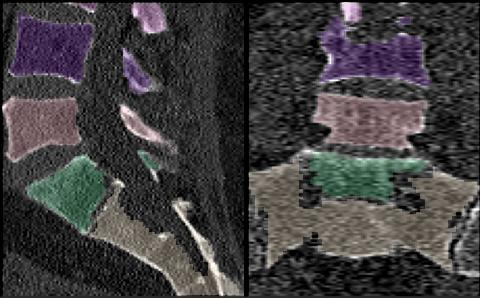

In [19]:
idx = castellvi_classes.index(31)

family = candidate_families[idx]
v_idx = lowest_vertebra[idx]

ct_nii, seg_nii = get_cutout(family, [23,24,25,26], return_seg=True)
ct_nii.save("/tmp/cutout_ct.nii.gz")
seg_nii.save("/tmp/cutout_seg_msk.nii.gz")
ct_file = Path("/tmp/cutout_ct.nii.gz")
seg_file = Path("/tmp/cutout_seg_msk.nii.gz")
out_file = Path("/tmp/cutout_lowest_snapshot.jpg")
mip_frame = Snapshot_Frame(ct_file,segmentation=seg_file,sagittal=True,coronal=True,mode="CT")
create_snapshot(out_file,[mip_frame])
Image(filename=out_file) 